**Assignment 16 - Neural Networks**

**2nd Problem Statement**

Predicting turbine energy yield (TEY) using ambient variables as features.

Dataset --> gas_turbines.csv

In [ ]:
# Importing the necessary packages
import pandas as pd
import numpy as np
import keras
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

#For Batch Size & Epoch: Importing the necessary packages
from sklearn.model_selection import GridSearchCV, KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam

#For Dropout : Importing the Necessary packages
from keras.layers import Dropout

In [ ]:
#Loading the Dataset
Dataset = pd.read_csv("C:Users/Akaash/Downloads/gas_turbines.csv")
Dataset.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311


***Pre-Processing / EDA***

In [ ]:
#Stats of the Dataset
Dataset.describe()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
count,15039.000000,15039.00000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000
mean,17.764381,1013.19924,79.124174,4.200294,25.419061,1083.798770,545.396183,134.188464,12.102353,1.972499,68.190934
std,7.574323,6.41076,13.793439,0.760197,4.173916,16.527806,7.866803,15.829717,1.103196,2.222206,10.470586
min,0.522300,985.85000,30.344000,2.087400,17.878000,1000.800000,512.450000,100.170000,9.904400,0.000388,27.765000
25%,11.408000,1008.90000,69.750000,3.723900,23.294000,1079.600000,542.170000,127.985000,11.622000,0.858055,61.303500
50%,18.186000,1012.80000,82.266000,4.186200,25.082000,1088.700000,549.890000,133.780000,12.025000,1.390200,66.601000
75%,23.862500,1016.90000,90.043500,4.550900,27.184000,1096.000000,550.060000,140.895000,12.578000,2.160400,73.935500
max,34.929000,1034.20000,100.200000,7.610600,37.402000,1100.800000,550.610000,174.610000,15.081000,44.103000,119.890000


In [ ]:
#Checking for NA & Dtypes
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      15039 non-null  float64
 1   AP      15039 non-null  float64
 2   AH      15039 non-null  float64
 3   AFDP    15039 non-null  float64
 4   GTEP    15039 non-null  float64
 5   TIT     15039 non-null  float64
 6   TAT     15039 non-null  float64
 7   TEY     15039 non-null  float64
 8   CDP     15039 non-null  float64
 9   CO      15039 non-null  float64
 10  NOX     15039 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


Inference: No NA Values Present, Also "TEY" is Our Y Variable as Per problem statement, Which is a Continuous variable, So Converting it by Creating a buckets of levels i.e.(Median of TEY)

In [ ]:
#Getting the Median of TEY to make Buckets of Data
print(Dataset['TEY'].median())

133.78


In [ ]:
#Creating a new Column with two bucket of Data for TEY
Dataset["tey"]= "<=133.78"
#Setting Bucket Based on Median Value of Original TEY Variables 
Dataset.loc[Dataset["TEY"]>=133.78,"tey"]=">=133.78"
Dataset.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX,tey
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722,<=133.78
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776,<=133.78
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468,<=133.78
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670,<=133.78
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311,<=133.78


Inference: Now the New 'tey' column has Two Label/Bucket Assigned based on Median of TEY (Y) Variable, then will Drop the Original TEY Variable

In [ ]:
#Dropping TEY column from the data 
Dataset.drop(["TEY"],axis=1,inplace = True)
Dataset.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,CDP,CO,NOX,tey
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,10.605,3.1547,82.722,<=133.78
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,10.598,3.2363,82.776,<=133.78
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,10.601,3.2012,82.468,<=133.78
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,10.606,3.1923,82.670,<=133.78
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,10.612,3.2484,82.311,<=133.78


Inference: Original 'TEY' is Dropped.

Now Will Do Encoding for Y Variable Label Encoding.

In [ ]:
#Applying lable encoder to TEY column
label_encoder = LabelEncoder()
Dataset['tey'] = label_encoder.fit_transform(Dataset['tey']) 
Dataset.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,CDP,CO,NOX,tey
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,10.605,3.1547,82.722,0
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,10.598,3.2363,82.776,0
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,10.601,3.2012,82.468,0
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,10.606,3.1923,82.670,0
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,10.612,3.2484,82.311,0


Inference: Dataset is Completed, Now Will Split X & Y Variable

In [ ]:
# split into input (X) and output (Y) variables
X = Dataset.iloc[:,0:10]
Y = Dataset.iloc[:,10]

Inference: Dataset is Splited, Now will Scale Down the Scaling Effect Using Standard Scaler

In [ ]:
# Standardization
a = StandardScaler()
a.fit(X)
X_standardized = a.transform(X)

Inference: Now Scaling Effect is Gone and the Values ranges from -3 to +3 sigma

**Base Line Model**

In [ ]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=10, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(4,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dense(1,activation = 'sigmoid'))
    
    #Compile Model
    adam = Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model


#Create the model

model = KerasClassifier(build_fn = baseline_model,verbose = 0,batch_size = 10,epochs = 100)

# Fitting the model

model.fit(X_standardized,Y)

# Predicting using trained model

y_predict = model.predict(X_standardized)

# Printing the metrics
print(accuracy_score(Y,y_predict)*100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


91.0698849657557


Inference: The BaseLine Model Has a Accuracy of 91.06%, Now Will Hypertune The Parameter

#### Tuning of Hyperparameters :- Batch Size and Epochs

In [ ]:
# create model
def create_model():
    model = Sequential()
    #When you get initializer Error pass this below parameter
    #kernel_initializer = 'uniform'
    model.add(Dense(12, input_dim=10,kernel_initializer = 'normal', activation='relu'))
    model.add(Dense(4,kernel_initializer = 'normal', activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    adam=Adam(lr=0.01)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

# Create the model
model = KerasClassifier(build_fn = create_model,verbose = 0)
# Define the grid search parameters
batch_size = [10,20,40]
epochs = [10,50,100]
# Make a dictionary of the grid search parameters
param_grid = dict(batch_size = batch_size,epochs = epochs)
# Build and fit the GridSearchCV
grid = GridSearchCV(estimator = model,param_grid = param_grid,cv = KFold(),verbose = 10)
grid_result = grid.fit(X_standardized,Y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START batch_size=10, epochs=10....................................
[CV 1/5; 1/9] END .....batch_size=10, epochs=10;, score=0.895 total time=  21.4s
[CV 2/5; 1/9] START batch_size=10, epochs=10....................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 1/9] END .....batch_size=10, epochs=10;, score=0.801 total time=  13.3s
[CV 3/5; 1/9] START batch_size=10, epochs=10....................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 1/9] END .....batch_size=10, epochs=10;, score=0.852 total time=  13.6s
[CV 4/5; 1/9] START batch_size=10, epochs=10....................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 1/9] END .....batch_size=10, epochs=10;, score=0.911 total time=  13.7s
[CV 5/5; 1/9] START batch_size=10, epochs=10....................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 1/9] END .....batch_size=10, epochs=10;, score=0.893 total time=  21.3s
[CV 1/5; 2/9] START batch_size=10, epochs=50....................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 2/9] END .....batch_size=10, epochs=50;, score=0.912 total time= 1.4min
[CV 2/5; 2/9] START batch_size=10, epochs=50....................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 2/9] END .....batch_size=10, epochs=50;, score=0.739 total time= 1.1min
[CV 3/5; 2/9] START batch_size=10, epochs=50....................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 2/9] END .....batch_size=10, epochs=50;, score=0.846 total time= 1.1min
[CV 4/5; 2/9] START batch_size=10, epochs=50....................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 2/9] END .....batch_size=10, epochs=50;, score=0.905 total time= 1.1min
[CV 5/5; 2/9] START batch_size=10, epochs=50....................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 2/9] END .....batch_size=10, epochs=50;, score=0.874 total time= 1.1min
[CV 1/5; 3/9] START batch_size=10, epochs=100...................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 3/9] END ....batch_size=10, epochs=100;, score=0.898 total time= 2.1min
[CV 2/5; 3/9] START batch_size=10, epochs=100...................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 3/9] END ....batch_size=10, epochs=100;, score=0.837 total time= 2.4min
[CV 3/5; 3/9] START batch_size=10, epochs=100...................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 3/9] END ....batch_size=10, epochs=100;, score=0.814 total time= 2.2min
[CV 4/5; 3/9] START batch_size=10, epochs=100...................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 3/9] END ....batch_size=10, epochs=100;, score=0.899 total time= 2.4min
[CV 5/5; 3/9] START batch_size=10, epochs=100...................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 3/9] END ....batch_size=10, epochs=100;, score=0.886 total time= 2.4min
[CV 1/5; 4/9] START batch_size=20, epochs=10....................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 4/9] END .....batch_size=20, epochs=10;, score=0.901 total time=  10.9s
[CV 2/5; 4/9] START batch_size=20, epochs=10....................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 4/9] END .....batch_size=20, epochs=10;, score=0.823 total time=   7.2s
[CV 3/5; 4/9] START batch_size=20, epochs=10....................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 4/9] END .....batch_size=20, epochs=10;, score=0.865 total time=   7.1s
[CV 4/5; 4/9] START batch_size=20, epochs=10....................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 4/9] END .....batch_size=20, epochs=10;, score=0.524 total time=   7.3s
[CV 5/5; 4/9] START batch_size=20, epochs=10....................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 4/9] END .....batch_size=20, epochs=10;, score=0.882 total time=  11.0s
[CV 1/5; 5/9] START batch_size=20, epochs=50....................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 5/9] END .....batch_size=20, epochs=50;, score=0.902 total time=  41.7s
[CV 2/5; 5/9] START batch_size=20, epochs=50....................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 5/9] END .....batch_size=20, epochs=50;, score=0.841 total time=  41.7s
[CV 3/5; 5/9] START batch_size=20, epochs=50....................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 5/9] END .....batch_size=20, epochs=50;, score=0.831 total time=  41.7s
[CV 4/5; 5/9] START batch_size=20, epochs=50....................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 5/9] END .....batch_size=20, epochs=50;, score=0.913 total time=  41.7s
[CV 5/5; 5/9] START batch_size=20, epochs=50....................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 5/9] END .....batch_size=20, epochs=50;, score=0.888 total time=  42.0s
[CV 1/5; 6/9] START batch_size=20, epochs=100...................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 6/9] END ....batch_size=20, epochs=100;, score=0.909 total time= 1.1min
[CV 2/5; 6/9] START batch_size=20, epochs=100...................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 6/9] END ....batch_size=20, epochs=100;, score=0.816 total time= 1.1min
[CV 3/5; 6/9] START batch_size=20, epochs=100...................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 6/9] END ....batch_size=20, epochs=100;, score=0.823 total time= 1.4min
[CV 4/5; 6/9] START batch_size=20, epochs=100...................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 6/9] END ....batch_size=20, epochs=100;, score=0.902 total time= 1.4min
[CV 5/5; 6/9] START batch_size=20, epochs=100...................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 6/9] END ....batch_size=20, epochs=100;, score=0.885 total time= 1.4min
[CV 1/5; 7/9] START batch_size=40, epochs=10....................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 7/9] END .....batch_size=40, epochs=10;, score=0.919 total time=   4.0s
[CV 2/5; 7/9] START batch_size=40, epochs=10....................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 7/9] END .....batch_size=40, epochs=10;, score=0.840 total time=   5.8s
[CV 3/5; 7/9] START batch_size=40, epochs=10....................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 7/9] END .....batch_size=40, epochs=10;, score=0.822 total time=   4.0s
[CV 4/5; 7/9] START batch_size=40, epochs=10....................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 7/9] END .....batch_size=40, epochs=10;, score=0.913 total time=   5.8s
[CV 5/5; 7/9] START batch_size=40, epochs=10....................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 7/9] END .....batch_size=40, epochs=10;, score=0.893 total time=   6.0s
[CV 1/5; 8/9] START batch_size=40, epochs=50....................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 8/9] END .....batch_size=40, epochs=50;, score=0.919 total time=  16.9s
[CV 2/5; 8/9] START batch_size=40, epochs=50....................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 8/9] END .....batch_size=40, epochs=50;, score=0.818 total time=  17.4s
[CV 3/5; 8/9] START batch_size=40, epochs=50....................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 8/9] END .....batch_size=40, epochs=50;, score=0.835 total time=  17.3s
[CV 4/5; 8/9] START batch_size=40, epochs=50....................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 8/9] END .....batch_size=40, epochs=50;, score=0.906 total time=  21.1s
[CV 5/5; 8/9] START batch_size=40, epochs=50....................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 8/9] END .....batch_size=40, epochs=50;, score=0.885 total time=  17.0s
[CV 1/5; 9/9] START batch_size=40, epochs=100...................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 9/9] END ....batch_size=40, epochs=100;, score=0.911 total time=  33.8s
[CV 2/5; 9/9] START batch_size=40, epochs=100...................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 9/9] END ....batch_size=40, epochs=100;, score=0.842 total time=  41.6s
[CV 3/5; 9/9] START batch_size=40, epochs=100...................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 9/9] END ....batch_size=40, epochs=100;, score=0.824 total time=  33.2s
[CV 4/5; 9/9] START batch_size=40, epochs=100...................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 9/9] END ....batch_size=40, epochs=100;, score=0.915 total time=  32.6s
[CV 5/5; 9/9] START batch_size=40, epochs=100...................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 9/9] END ....batch_size=40, epochs=100;, score=0.881 total time=  42.0s


In [ ]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print('{},{} with: {}'.format(mean, stdev, param))

Best : 0.8775859951972962, using {'batch_size': 40, 'epochs': 10}
0.8705381035804749,0.03985220683525299 with: {'batch_size': 10, 'epochs': 10}
0.8549782991409302,0.06274471937233365 with: {'batch_size': 10, 'epochs': 50}
0.8666812300682067,0.034487715168463086 with: {'batch_size': 10, 'epochs': 100}
0.7990612983703613,0.13991978008070088 with: {'batch_size': 20, 'epochs': 10}
0.8747265577316284,0.032930730613329545 with: {'batch_size': 20, 'epochs': 50}
0.8670136451721191,0.039475156766462606 with: {'batch_size': 20, 'epochs': 100}
0.8775859951972962,0.03919286256569776 with: {'batch_size': 40, 'epochs': 10}
0.8725322842597961,0.03958780651626725 with: {'batch_size': 40, 'epochs': 50}
0.874726140499115,0.03621934910569913 with: {'batch_size': 40, 'epochs': 100}


Inference: After Hyper Tuning Best Values For Parameter Batch_size = 40 & Epochs = 10

#### Tuning of Hyperparameters:- Learning rate and Drop out rate

In [ ]:
# Defining the model

def create_model(learning_rate,dropout_rate):
    model = Sequential()
    model.add(Dense(12,input_dim = 10,kernel_initializer = 'normal',activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4,kernel_initializer = 'normal',activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = learning_rate)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

# Create the model

model = KerasClassifier(build_fn = create_model,verbose = 0,batch_size = 40,epochs = 10)

# Define the grid search parameters

learning_rate = [0.001,0.01,0.1]
dropout_rate = [0.0,0.1,0.2]

# Make a dictionary of the grid search parameters

param_grids = dict(learning_rate = learning_rate,dropout_rate = dropout_rate)

# Build and fit the GridSearchCV

grid = GridSearchCV(estimator = model,param_grid = param_grids,cv = KFold(),verbose = 10)
grid_result = grid.fit(X_standardized,Y)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 1/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.912 total time=   5.9s
[CV 2/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.870 total time=   4.3s
[CV 3/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.833 total time=   5.9s
[CV 4/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.913 total time=   4.2s
[CV 5/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.885 total time=   4.2s
[CV 1/5; 2/9] START dropout_rate=0.0, learning_rate=0.01........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 2/9] END dropout_rate=0.0, learning_rate=0.01;, score=0.911 total time=   4.2s
[CV 2/5; 2/9] START dropout_rate=0.0, learning_rate=0.01........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 2/9] END dropout_rate=0.0, learning_rate=0.01;, score=0.857 total time=   4.1s
[CV 3/5; 2/9] START dropout_rate=0.0, learning_rate=0.01........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 2/9] END dropout_rate=0.0, learning_rate=0.01;, score=0.844 total time=   6.1s
[CV 4/5; 2/9] START dropout_rate=0.0, learning_rate=0.01........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 2/9] END dropout_rate=0.0, learning_rate=0.01;, score=0.907 total time=   4.1s
[CV 5/5; 2/9] START dropout_rate=0.0, learning_rate=0.01........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 2/9] END dropout_rate=0.0, learning_rate=0.01;, score=0.887 total time=   5.8s
[CV 1/5; 3/9] START dropout_rate=0.0, learning_rate=0.1.........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 3/9] END dropout_rate=0.0, learning_rate=0.1;, score=0.899 total time=   5.8s
[CV 2/5; 3/9] START dropout_rate=0.0, learning_rate=0.1.........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 3/9] END dropout_rate=0.0, learning_rate=0.1;, score=0.849 total time=   4.1s
[CV 3/5; 3/9] START dropout_rate=0.0, learning_rate=0.1.........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 3/9] END dropout_rate=0.0, learning_rate=0.1;, score=0.821 total time=   5.8s
[CV 4/5; 3/9] START dropout_rate=0.0, learning_rate=0.1.........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 3/9] END dropout_rate=0.0, learning_rate=0.1;, score=0.908 total time=   5.8s
[CV 5/5; 3/9] START dropout_rate=0.0, learning_rate=0.1.........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 3/9] END dropout_rate=0.0, learning_rate=0.1;, score=0.890 total time=   5.9s
[CV 1/5; 4/9] START dropout_rate=0.1, learning_rate=0.001.......................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 4/9] END dropout_rate=0.1, learning_rate=0.001;, score=0.913 total time=   4.4s
[CV 2/5; 4/9] START dropout_rate=0.1, learning_rate=0.001.......................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 4/9] END dropout_rate=0.1, learning_rate=0.001;, score=0.855 total time=   4.2s
[CV 3/5; 4/9] START dropout_rate=0.1, learning_rate=0.001.......................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 4/9] END dropout_rate=0.1, learning_rate=0.001;, score=0.858 total time=   6.2s
[CV 4/5; 4/9] START dropout_rate=0.1, learning_rate=0.001.......................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 4/9] END dropout_rate=0.1, learning_rate=0.001;, score=0.907 total time=   4.3s
[CV 5/5; 4/9] START dropout_rate=0.1, learning_rate=0.001.......................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 4/9] END dropout_rate=0.1, learning_rate=0.001;, score=0.883 total time=   5.9s
[CV 1/5; 5/9] START dropout_rate=0.1, learning_rate=0.01........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 5/9] END dropout_rate=0.1, learning_rate=0.01;, score=0.905 total time=   5.9s
[CV 2/5; 5/9] START dropout_rate=0.1, learning_rate=0.01........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 5/9] END dropout_rate=0.1, learning_rate=0.01;, score=0.868 total time=   5.9s
[CV 3/5; 5/9] START dropout_rate=0.1, learning_rate=0.01........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 5/9] END dropout_rate=0.1, learning_rate=0.01;, score=0.828 total time=   4.2s
[CV 4/5; 5/9] START dropout_rate=0.1, learning_rate=0.01........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 5/9] END dropout_rate=0.1, learning_rate=0.01;, score=0.913 total time=   4.3s
[CV 5/5; 5/9] START dropout_rate=0.1, learning_rate=0.01........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 5/9] END dropout_rate=0.1, learning_rate=0.01;, score=0.890 total time=   4.2s
[CV 1/5; 6/9] START dropout_rate=0.1, learning_rate=0.1.........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 6/9] END dropout_rate=0.1, learning_rate=0.1;, score=0.923 total time=   5.8s
[CV 2/5; 6/9] START dropout_rate=0.1, learning_rate=0.1.........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 6/9] END dropout_rate=0.1, learning_rate=0.1;, score=0.847 total time=   5.8s
[CV 3/5; 6/9] START dropout_rate=0.1, learning_rate=0.1.........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 6/9] END dropout_rate=0.1, learning_rate=0.1;, score=0.830 total time=   6.2s
[CV 4/5; 6/9] START dropout_rate=0.1, learning_rate=0.1.........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 6/9] END dropout_rate=0.1, learning_rate=0.1;, score=0.907 total time=   4.2s
[CV 5/5; 6/9] START dropout_rate=0.1, learning_rate=0.1.........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 6/9] END dropout_rate=0.1, learning_rate=0.1;, score=0.881 total time=   4.3s
[CV 1/5; 7/9] START dropout_rate=0.2, learning_rate=0.001.......................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 7/9] END dropout_rate=0.2, learning_rate=0.001;, score=0.925 total time=   4.3s
[CV 2/5; 7/9] START dropout_rate=0.2, learning_rate=0.001.......................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 7/9] END dropout_rate=0.2, learning_rate=0.001;, score=0.876 total time=   5.8s
[CV 3/5; 7/9] START dropout_rate=0.2, learning_rate=0.001.......................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 7/9] END dropout_rate=0.2, learning_rate=0.001;, score=0.854 total time=   5.9s
[CV 4/5; 7/9] START dropout_rate=0.2, learning_rate=0.001.......................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 7/9] END dropout_rate=0.2, learning_rate=0.001;, score=0.915 total time=   4.2s
[CV 5/5; 7/9] START dropout_rate=0.2, learning_rate=0.001.......................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 7/9] END dropout_rate=0.2, learning_rate=0.001;, score=0.884 total time=   4.3s
[CV 1/5; 8/9] START dropout_rate=0.2, learning_rate=0.01........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 8/9] END dropout_rate=0.2, learning_rate=0.01;, score=0.921 total time=   4.3s
[CV 2/5; 8/9] START dropout_rate=0.2, learning_rate=0.01........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 8/9] END dropout_rate=0.2, learning_rate=0.01;, score=0.861 total time=   5.8s
[CV 3/5; 8/9] START dropout_rate=0.2, learning_rate=0.01........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 8/9] END dropout_rate=0.2, learning_rate=0.01;, score=0.847 total time=   6.1s
[CV 4/5; 8/9] START dropout_rate=0.2, learning_rate=0.01........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 8/9] END dropout_rate=0.2, learning_rate=0.01;, score=0.918 total time=   5.9s
[CV 5/5; 8/9] START dropout_rate=0.2, learning_rate=0.01........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 8/9] END dropout_rate=0.2, learning_rate=0.01;, score=0.883 total time=   4.2s
[CV 1/5; 9/9] START dropout_rate=0.2, learning_rate=0.1.........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 9/9] END dropout_rate=0.2, learning_rate=0.1;, score=0.848 total time=   4.2s
[CV 2/5; 9/9] START dropout_rate=0.2, learning_rate=0.1.........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 9/9] END dropout_rate=0.2, learning_rate=0.1;, score=0.887 total time=   5.9s
[CV 3/5; 9/9] START dropout_rate=0.2, learning_rate=0.1.........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 9/9] END dropout_rate=0.2, learning_rate=0.1;, score=0.792 total time=   4.3s
[CV 4/5; 9/9] START dropout_rate=0.2, learning_rate=0.1.........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 9/9] END dropout_rate=0.2, learning_rate=0.1;, score=0.918 total time=   5.9s
[CV 5/5; 9/9] START dropout_rate=0.2, learning_rate=0.1.........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 9/9] END dropout_rate=0.2, learning_rate=0.1;, score=0.853 total time=   5.9s


In [ ]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print('{},{} with: {}'.format(mean, stdev, param))

Best : 0.8908167600631713, using {'dropout_rate': 0.2, 'learning_rate': 0.001}
0.8825056314468384,0.029627611411350348 with: {'dropout_rate': 0.0, 'learning_rate': 0.001}
0.8808435320854187,0.026598766563638895 with: {'dropout_rate': 0.0, 'learning_rate': 0.01}
0.8735299348831177,0.03296630014199621 with: {'dropout_rate': 0.0, 'learning_rate': 0.1}
0.8831704258918762,0.023812735758628994 with: {'dropout_rate': 0.1, 'learning_rate': 0.001}
0.8807107448577881,0.030318295629373486 with: {'dropout_rate': 0.1, 'learning_rate': 0.01}
0.8775851964950562,0.0347537065486876 with: {'dropout_rate': 0.1, 'learning_rate': 0.1}
0.8908167600631713,0.025871003089631955 with: {'dropout_rate': 0.2, 'learning_rate': 0.001}
0.8860294699668885,0.02960110927820666 with: {'dropout_rate': 0.2, 'learning_rate': 0.01}
0.8595647215843201,0.04215465162693739 with: {'dropout_rate': 0.2, 'learning_rate': 0.1}


Inference: After Hyper Tuning Best Values For Parameter dropout_rate = 0.2 & Learning_rate = 0.001

#### Tuning of Hyperparameters:- Activation Function and Kernel Initializer

In [ ]:
# Defining the model

def create_model(activation_function,init):
    model = Sequential()
    model.add(Dense(12,input_dim = 10,kernel_initializer = init,activation = activation_function))
    model.add(Dropout(0.2))
    model.add(Dense(4,kernel_initializer = init,activation = activation_function))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

# Create the model

model = KerasClassifier(build_fn = create_model,verbose = 0,batch_size = 40,epochs = 10)

# Define the grid search parameters
activation_function = ['softmax','relu','tanh','linear']
init = ['uniform','normal','zero']

# Make a dictionary of the grid search parameters
param_grids = dict(activation_function = activation_function,init = init)

# Build and fit the GridSearchCV

grid = GridSearchCV(estimator = model,param_grid = param_grids,cv = KFold(),verbose = 10)
grid_result = grid.fit(X_standardized,Y)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 1/5; 1/12] END activation_function=softmax, init=uniform;, score=0.905 total time=   5.9s
[CV 2/5; 1/12] START activation_function=softmax, init=uniform..................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 1/12] END activation_function=softmax, init=uniform;, score=0.829 total time=   6.3s
[CV 3/5; 1/12] START activation_function=softmax, init=uniform..................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 1/12] END activation_function=softmax, init=uniform;, score=0.809 total time=   4.4s
[CV 4/5; 1/12] START activation_function=softmax, init=uniform..................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 1/12] END activation_function=softmax, init=uniform;, score=0.918 total time=   5.9s
[CV 5/5; 1/12] START activation_function=softmax, init=uniform..................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 1/12] END activation_function=softmax, init=uniform;, score=0.876 total time=   4.4s
[CV 1/5; 2/12] START activation_function=softmax, init=normal...................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 2/12] END activation_function=softmax, init=normal;, score=0.903 total time=   5.8s
[CV 2/5; 2/12] START activation_function=softmax, init=normal...................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 2/12] END activation_function=softmax, init=normal;, score=0.831 total time=   4.4s
[CV 3/5; 2/12] START activation_function=softmax, init=normal...................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 2/12] END activation_function=softmax, init=normal;, score=0.807 total time=   4.2s
[CV 4/5; 2/12] START activation_function=softmax, init=normal...................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 2/12] END activation_function=softmax, init=normal;, score=0.916 total time=   4.4s
[CV 5/5; 2/12] START activation_function=softmax, init=normal...................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 2/12] END activation_function=softmax, init=normal;, score=0.877 total time=   4.3s
[CV 1/5; 3/12] START activation_function=softmax, init=zero.....................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 3/12] END activation_function=softmax, init=zero;, score=0.896 total time=   5.9s
[CV 2/5; 3/12] START activation_function=softmax, init=zero.....................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 3/12] END activation_function=softmax, init=zero;, score=0.821 total time=   4.5s
[CV 3/5; 3/12] START activation_function=softmax, init=zero.....................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 3/12] END activation_function=softmax, init=zero;, score=0.806 total time=   4.3s
[CV 4/5; 3/12] START activation_function=softmax, init=zero.....................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 3/12] END activation_function=softmax, init=zero;, score=0.920 total time=   4.3s
[CV 5/5; 3/12] START activation_function=softmax, init=zero.....................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 3/12] END activation_function=softmax, init=zero;, score=0.874 total time=   4.2s
[CV 1/5; 4/12] START activation_function=relu, init=uniform.....................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 4/12] END activation_function=relu, init=uniform;, score=0.927 total time=   4.2s
[CV 2/5; 4/12] START activation_function=relu, init=uniform.....................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 4/12] END activation_function=relu, init=uniform;, score=0.864 total time=   5.9s
[CV 3/5; 4/12] START activation_function=relu, init=uniform.....................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 4/12] END activation_function=relu, init=uniform;, score=0.844 total time=   4.1s
[CV 4/5; 4/12] START activation_function=relu, init=uniform.....................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 4/12] END activation_function=relu, init=uniform;, score=0.905 total time=   4.2s
[CV 5/5; 4/12] START activation_function=relu, init=uniform.....................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 4/12] END activation_function=relu, init=uniform;, score=0.887 total time=   5.8s
[CV 1/5; 5/12] START activation_function=relu, init=normal......................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 5/12] END activation_function=relu, init=normal;, score=0.918 total time=   5.8s
[CV 2/5; 5/12] START activation_function=relu, init=normal......................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 5/12] END activation_function=relu, init=normal;, score=0.874 total time=   4.7s
[CV 3/5; 5/12] START activation_function=relu, init=normal......................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 5/12] END activation_function=relu, init=normal;, score=0.846 total time=   5.9s
[CV 4/5; 5/12] START activation_function=relu, init=normal......................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 5/12] END activation_function=relu, init=normal;, score=0.912 total time=   4.3s
[CV 5/5; 5/12] START activation_function=relu, init=normal......................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 5/12] END activation_function=relu, init=normal;, score=0.887 total time=   4.4s
[CV 1/5; 6/12] START activation_function=relu, init=zero........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 6/12] END activation_function=relu, init=zero;, score=0.507 total time=   5.9s
[CV 2/5; 6/12] START activation_function=relu, init=zero........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 6/12] END activation_function=relu, init=zero;, score=0.497 total time=   5.8s
[CV 3/5; 6/12] START activation_function=relu, init=zero........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 6/12] END activation_function=relu, init=zero;, score=0.444 total time=   5.9s
[CV 4/5; 6/12] START activation_function=relu, init=zero........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 6/12] END activation_function=relu, init=zero;, score=0.524 total time=   5.9s
[CV 5/5; 6/12] START activation_function=relu, init=zero........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 6/12] END activation_function=relu, init=zero;, score=0.462 total time=   5.8s
[CV 1/5; 7/12] START activation_function=tanh, init=uniform.....................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 7/12] END activation_function=tanh, init=uniform;, score=0.928 total time=   5.9s
[CV 2/5; 7/12] START activation_function=tanh, init=uniform.....................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 7/12] END activation_function=tanh, init=uniform;, score=0.871 total time=   6.2s
[CV 3/5; 7/12] START activation_function=tanh, init=uniform.....................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 7/12] END activation_function=tanh, init=uniform;, score=0.852 total time=   5.8s
[CV 4/5; 7/12] START activation_function=tanh, init=uniform.....................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 7/12] END activation_function=tanh, init=uniform;, score=0.901 total time=   4.2s
[CV 5/5; 7/12] START activation_function=tanh, init=uniform.....................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 7/12] END activation_function=tanh, init=uniform;, score=0.881 total time=   5.8s
[CV 1/5; 8/12] START activation_function=tanh, init=normal......................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 8/12] END activation_function=tanh, init=normal;, score=0.930 total time=   5.9s
[CV 2/5; 8/12] START activation_function=tanh, init=normal......................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 8/12] END activation_function=tanh, init=normal;, score=0.882 total time=   4.2s
[CV 3/5; 8/12] START activation_function=tanh, init=normal......................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 8/12] END activation_function=tanh, init=normal;, score=0.856 total time=   5.9s
[CV 4/5; 8/12] START activation_function=tanh, init=normal......................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 8/12] END activation_function=tanh, init=normal;, score=0.917 total time=   5.8s
[CV 5/5; 8/12] START activation_function=tanh, init=normal......................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 8/12] END activation_function=tanh, init=normal;, score=0.877 total time=   5.9s
[CV 1/5; 9/12] START activation_function=tanh, init=zero........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 9/12] END activation_function=tanh, init=zero;, score=0.507 total time=   4.3s
[CV 2/5; 9/12] START activation_function=tanh, init=zero........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 9/12] END activation_function=tanh, init=zero;, score=0.497 total time=   6.3s
[CV 3/5; 9/12] START activation_function=tanh, init=zero........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 9/12] END activation_function=tanh, init=zero;, score=0.556 total time=   4.2s
[CV 4/5; 9/12] START activation_function=tanh, init=zero........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 9/12] END activation_function=tanh, init=zero;, score=0.524 total time=   5.9s
[CV 5/5; 9/12] START activation_function=tanh, init=zero........................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 9/12] END activation_function=tanh, init=zero;, score=0.462 total time=   5.9s
[CV 1/5; 10/12] START activation_function=linear, init=uniform..................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 10/12] END activation_function=linear, init=uniform;, score=0.919 total time=   4.3s
[CV 2/5; 10/12] START activation_function=linear, init=uniform..................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 10/12] END activation_function=linear, init=uniform;, score=0.879 total time=   4.3s
[CV 3/5; 10/12] START activation_function=linear, init=uniform..................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 10/12] END activation_function=linear, init=uniform;, score=0.866 total time=   5.8s
[CV 4/5; 10/12] START activation_function=linear, init=uniform..................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 10/12] END activation_function=linear, init=uniform;, score=0.918 total time=   5.8s
[CV 5/5; 10/12] START activation_function=linear, init=uniform..................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 10/12] END activation_function=linear, init=uniform;, score=0.875 total time=   5.9s
[CV 1/5; 11/12] START activation_function=linear, init=normal...................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 11/12] END activation_function=linear, init=normal;, score=0.920 total time=   5.8s
[CV 2/5; 11/12] START activation_function=linear, init=normal...................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 11/12] END activation_function=linear, init=normal;, score=0.881 total time=   4.6s
[CV 3/5; 11/12] START activation_function=linear, init=normal...................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 11/12] END activation_function=linear, init=normal;, score=0.855 total time=   4.2s
[CV 4/5; 11/12] START activation_function=linear, init=normal...................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 11/12] END activation_function=linear, init=normal;, score=0.917 total time=   5.9s
[CV 5/5; 11/12] START activation_function=linear, init=normal...................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 11/12] END activation_function=linear, init=normal;, score=0.887 total time=   5.8s
[CV 1/5; 12/12] START activation_function=linear, init=zero.....................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 12/12] END activation_function=linear, init=zero;, score=0.507 total time=   5.9s
[CV 2/5; 12/12] START activation_function=linear, init=zero.....................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 12/12] END activation_function=linear, init=zero;, score=0.497 total time=   5.9s
[CV 3/5; 12/12] START activation_function=linear, init=zero.....................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 12/12] END activation_function=linear, init=zero;, score=0.444 total time=   5.9s
[CV 4/5; 12/12] START activation_function=linear, init=zero.....................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 12/12] END activation_function=linear, init=zero;, score=0.524 total time=   5.8s
[CV 5/5; 12/12] START activation_function=linear, init=zero.....................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 12/12] END activation_function=linear, init=zero;, score=0.462 total time=   5.8s


In [ ]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print('{},{} with: {}'.format(mean, stdev, param))

Best : 0.8925450325012207, using {'activation_function': 'tanh', 'init': 'normal'}
0.867411983013153,0.04231360704475343 with: {'activation_function': 'softmax', 'init': 'uniform'}
0.8667471408843994,0.04167695537352402 with: {'activation_function': 'softmax', 'init': 'normal'}
0.8634889841079711,0.04359568824759784 with: {'activation_function': 'softmax', 'init': 'zero'}
0.8852983355522156,0.02930472674460287 with: {'activation_function': 'relu', 'init': 'uniform'}
0.8874925136566162,0.02593996238227195 with: {'activation_function': 'relu', 'init': 'normal'}
0.48673285245895387,0.029441256338920252 with: {'activation_function': 'relu', 'init': 'zero'}
0.8866277456283569,0.025900918869670494 with: {'activation_function': 'tanh', 'init': 'uniform'}
0.8925450325012207,0.027274443394219642 with: {'activation_function': 'tanh', 'init': 'normal'}
0.5092062592506409,0.030952375826419014 with: {'activation_function': 'tanh', 'init': 'zero'}
0.8912150621414184,0.022405680275929037 with: {'acti

Inference: After Hyper Tuning Best Values For Parameter activation Function = tanh & init = normal

#### Tuning of Hyperparameter :-Number of Neurons in activation layer

In [ ]:
# Defining the model

def create_model(neuron1,neuron2):
    model = Sequential()
    model.add(Dense(neuron1,input_dim = 10,kernel_initializer = 'normal',activation = 'tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(neuron2,kernel_initializer = 'normal',activation = 'tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

# Create the model

model = KerasClassifier(build_fn = create_model,verbose = 0,batch_size = 40,epochs = 10)

# Define the grid search parameters

neuron1 = [4,8,12]
neuron2 = [2,4,6]

# Make a dictionary of the grid search parameters

param_grids = dict(neuron1 = neuron1,neuron2 = neuron2)

# Build and fit the GridSearchCV

grid = GridSearchCV(estimator = model,param_grid = param_grids,cv = KFold(),verbose = 10)
grid_result = grid.fit(X_standardized,Y)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START neuron1=4, neuron2=2........................................
[CV 1/5; 1/9] END .........neuron1=4, neuron2=2;, score=0.926 total time=   6.3s
[CV 2/5; 1/9] START neuron1=4, neuron2=2........................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 1/9] END .........neuron1=4, neuron2=2;, score=0.873 total time=   4.3s
[CV 3/5; 1/9] START neuron1=4, neuron2=2........................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 1/9] END .........neuron1=4, neuron2=2;, score=0.835 total time=   4.3s
[CV 4/5; 1/9] START neuron1=4, neuron2=2........................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 1/9] END .........neuron1=4, neuron2=2;, score=0.911 total time=   4.3s
[CV 5/5; 1/9] START neuron1=4, neuron2=2........................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 1/9] END .........neuron1=4, neuron2=2;, score=0.876 total time=   5.9s
[CV 1/5; 2/9] START neuron1=4, neuron2=4........................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 2/9] END .........neuron1=4, neuron2=4;, score=0.925 total time=   4.3s
[CV 2/5; 2/9] START neuron1=4, neuron2=4........................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 2/9] END .........neuron1=4, neuron2=4;, score=0.878 total time=   4.2s
[CV 3/5; 2/9] START neuron1=4, neuron2=4........................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 2/9] END .........neuron1=4, neuron2=4;, score=0.857 total time=   5.9s
[CV 4/5; 2/9] START neuron1=4, neuron2=4........................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 2/9] END .........neuron1=4, neuron2=4;, score=0.912 total time=   4.3s
[CV 5/5; 2/9] START neuron1=4, neuron2=4........................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 2/9] END .........neuron1=4, neuron2=4;, score=0.879 total time=   5.9s
[CV 1/5; 3/9] START neuron1=4, neuron2=6........................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 3/9] END .........neuron1=4, neuron2=6;, score=0.918 total time=   4.5s
[CV 2/5; 3/9] START neuron1=4, neuron2=6........................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 3/9] END .........neuron1=4, neuron2=6;, score=0.883 total time=   4.2s
[CV 3/5; 3/9] START neuron1=4, neuron2=6........................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 3/9] END .........neuron1=4, neuron2=6;, score=0.856 total time=   5.8s
[CV 4/5; 3/9] START neuron1=4, neuron2=6........................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 3/9] END .........neuron1=4, neuron2=6;, score=0.917 total time=   4.2s
[CV 5/5; 3/9] START neuron1=4, neuron2=6........................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 3/9] END .........neuron1=4, neuron2=6;, score=0.882 total time=   4.3s
[CV 1/5; 4/9] START neuron1=8, neuron2=2........................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 4/9] END .........neuron1=8, neuron2=2;, score=0.925 total time=   4.3s
[CV 2/5; 4/9] START neuron1=8, neuron2=2........................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 4/9] END .........neuron1=8, neuron2=2;, score=0.876 total time=   5.9s
[CV 3/5; 4/9] START neuron1=8, neuron2=2........................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 4/9] END .........neuron1=8, neuron2=2;, score=0.833 total time=   5.9s
[CV 4/5; 4/9] START neuron1=8, neuron2=2........................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 4/9] END .........neuron1=8, neuron2=2;, score=0.920 total time=   5.9s
[CV 5/5; 4/9] START neuron1=8, neuron2=2........................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 4/9] END .........neuron1=8, neuron2=2;, score=0.884 total time=   5.8s
[CV 1/5; 5/9] START neuron1=8, neuron2=4........................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 5/9] END .........neuron1=8, neuron2=4;, score=0.922 total time=   6.2s
[CV 2/5; 5/9] START neuron1=8, neuron2=4........................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 5/9] END .........neuron1=8, neuron2=4;, score=0.866 total time=   5.9s
[CV 3/5; 5/9] START neuron1=8, neuron2=4........................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 5/9] END .........neuron1=8, neuron2=4;, score=0.856 total time=   4.2s
[CV 4/5; 5/9] START neuron1=8, neuron2=4........................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 5/9] END .........neuron1=8, neuron2=4;, score=0.908 total time=   4.3s
[CV 5/5; 5/9] START neuron1=8, neuron2=4........................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 5/9] END .........neuron1=8, neuron2=4;, score=0.874 total time=   5.9s
[CV 1/5; 6/9] START neuron1=8, neuron2=6........................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 6/9] END .........neuron1=8, neuron2=6;, score=0.928 total time=   5.9s
[CV 2/5; 6/9] START neuron1=8, neuron2=6........................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 6/9] END .........neuron1=8, neuron2=6;, score=0.875 total time=   4.3s
[CV 3/5; 6/9] START neuron1=8, neuron2=6........................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 6/9] END .........neuron1=8, neuron2=6;, score=0.845 total time=   5.9s
[CV 4/5; 6/9] START neuron1=8, neuron2=6........................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 6/9] END .........neuron1=8, neuron2=6;, score=0.920 total time=   5.8s
[CV 5/5; 6/9] START neuron1=8, neuron2=6........................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 6/9] END .........neuron1=8, neuron2=6;, score=0.886 total time=   4.3s
[CV 1/5; 7/9] START neuron1=12, neuron2=2.......................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 7/9] END ........neuron1=12, neuron2=2;, score=0.922 total time=   5.9s
[CV 2/5; 7/9] START neuron1=12, neuron2=2.......................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 7/9] END ........neuron1=12, neuron2=2;, score=0.877 total time=   4.6s
[CV 3/5; 7/9] START neuron1=12, neuron2=2.......................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 7/9] END ........neuron1=12, neuron2=2;, score=0.835 total time=   5.8s
[CV 4/5; 7/9] START neuron1=12, neuron2=2.......................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 7/9] END ........neuron1=12, neuron2=2;, score=0.914 total time=   5.9s
[CV 5/5; 7/9] START neuron1=12, neuron2=2.......................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 7/9] END ........neuron1=12, neuron2=2;, score=0.885 total time=   4.2s
[CV 1/5; 8/9] START neuron1=12, neuron2=4.......................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 8/9] END ........neuron1=12, neuron2=4;, score=0.915 total time=   5.8s
[CV 2/5; 8/9] START neuron1=12, neuron2=4.......................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 8/9] END ........neuron1=12, neuron2=4;, score=0.864 total time=   4.2s
[CV 3/5; 8/9] START neuron1=12, neuron2=4.......................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 8/9] END ........neuron1=12, neuron2=4;, score=0.854 total time=   4.2s
[CV 4/5; 8/9] START neuron1=12, neuron2=4.......................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 8/9] END ........neuron1=12, neuron2=4;, score=0.918 total time=   5.9s
[CV 5/5; 8/9] START neuron1=12, neuron2=4.......................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 8/9] END ........neuron1=12, neuron2=4;, score=0.882 total time=   4.4s
[CV 1/5; 9/9] START neuron1=12, neuron2=6.......................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 1/5; 9/9] END ........neuron1=12, neuron2=6;, score=0.911 total time=   4.1s
[CV 2/5; 9/9] START neuron1=12, neuron2=6.......................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 2/5; 9/9] END ........neuron1=12, neuron2=6;, score=0.871 total time=   6.1s
[CV 3/5; 9/9] START neuron1=12, neuron2=6.......................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 3/5; 9/9] END ........neuron1=12, neuron2=6;, score=0.861 total time=   5.8s
[CV 4/5; 9/9] START neuron1=12, neuron2=6.......................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 4/5; 9/9] END ........neuron1=12, neuron2=6;, score=0.902 total time=   5.8s
[CV 5/5; 9/9] START neuron1=12, neuron2=6.......................................


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[CV 5/5; 9/9] END ........neuron1=12, neuron2=6;, score=0.872 total time=   4.3s


In [ ]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print('{},{} with: {}'.format(mean, stdev, param))

Best : 0.8910825848579407, using {'neuron1': 4, 'neuron2': 6}
0.8842337727546692,0.03184450094526354 with: {'neuron1': 4, 'neuron2': 2}
0.8901515007019043,0.024903626064995462 with: {'neuron1': 4, 'neuron2': 4}
0.8910825848579407,0.023519608695954326 with: {'neuron1': 4, 'neuron2': 6}
0.8875587582588196,0.03338254210471091 with: {'neuron1': 8, 'neuron2': 2}
0.8852310061454773,0.025352019786161972 with: {'neuron1': 8, 'neuron2': 4}
0.8908168792724609,0.030338592103927243 with: {'neuron1': 8, 'neuron2': 6}
0.8865615010261536,0.03094717477051189 with: {'neuron1': 12, 'neuron2': 2}
0.8866277813911438,0.026196010455821442 with: {'neuron1': 12, 'neuron2': 4}
0.8830366849899292,0.019411936435254535 with: {'neuron1': 12, 'neuron2': 6}


Inference: After Hyper Tuning Best Values For Parameter Neuron1 = 4 & Neuron2 = 6

#### Training model with optimum values of Hyperparameters

In [ ]:
# Defining the model

def create_model():
    model = Sequential()
    model.add(Dense(4,input_dim = 10,kernel_initializer = 'normal',activation = 'tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(6,kernel_initializer = 'normal',activation = 'tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

# Create the model

model = KerasClassifier(build_fn = create_model,verbose = 0,batch_size = 40,epochs = 10)

# Fitting the model

model.fit(X_standardized,Y)

# Predicting using trained model

y_predict = model.predict(X_standardized)

# Printing the metrics
print(accuracy_score(Y,y_predict))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


0.9023871268036439


Inference: After Hyper Tuning Parameter The Final Training Accuracy is 90.2%

**Model Building - Train Test Split**

In [ ]:
#Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_standardized, Y, test_size = 0.33, random_state = 7)

def create_model():
    model = Sequential()
    model.add(Dense(4,input_dim = 10,kernel_initializer = 'normal',activation = 'tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(6,kernel_initializer = 'normal',activation = 'tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

# Create the model

model = KerasClassifier(build_fn = create_model,verbose = 0,batch_size = 40,epochs = 10)

# Fitting the model

model.fit(X_train,y_train)

# Predicting using trained model

y_predict = model.predict(X_test)

# Printing the metrics
print(accuracy_score(y_test,y_predict)*100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


89.84485190409028


Inference: The Test Data's Network Accuracy is 89.84%

**Visualize Training History**

In [ ]:
History=model.fit(X_standardized,Y,validation_split=0.33,epochs=10,batch_size=40)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
History.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

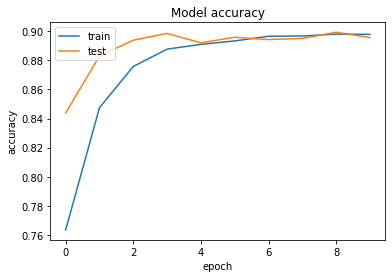

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Model accuracy")
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.legend(['train', 'test'], loc='upper left')

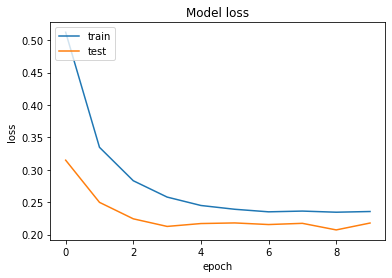

In [ ]:
# summarize history for loss
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Model loss")
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
print("Accuracy of model: "+str(np.mean(History.history['val_accuracy'])))
print("Loss of model: "+str(np.mean(History.history['val_loss'])))

Accuracy of model: 0.8890993356704712
Loss of model: 0.22941868156194686
